<a href="https://colab.research.google.com/github/Abhi23run/CSE8803_DLT_Project/blob/main/CodeBase/prompts_transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install be-great
!pip install openpyxl

In [3]:
from be_great import GReaT
import pandas as pd
import torch
import xlrd
from openpyxl import load_workbook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
## Reading in Schema file - Medical Claims
file_path = '/content/drive/MyDrive/Capgemini-Practicum/Dataset/Data Dictionary Medical Claims.xlsx'
df_medical_schema = pd.read_excel(file_path, skiprows=1)

In [6]:
column_indices_to_keep=[3,13,16,18,19,20,21,23,24,25,31,32,33,36,49,52,67,68,75,76,80]
##adjusting for indices
column_indices_to_keep=[i-3 for i in column_indices_to_keep]

In [7]:
df_medical_schema=df_medical_schema.iloc[column_indices_to_keep].reset_index(drop=True)

In [24]:
dtypes = {'_c21': 'str', '_c61': 'str','_c13':'str'}
df_medical_data = pd.read_csv("drive/MyDrive/Capgemini-Practicum/Dataset/medical_claims.csv.gz", usecols=column_indices_to_keep,dtype=dtypes)
print(df_medical_data.shape)

(8092330, 21)


In [25]:
df_medical_data.columns=list(df_medical_schema['Field'])

In [26]:
df_medical_data=df_medical_data[df_medical_data['Member Life ID']!=-1].reset_index(drop=True)

In [27]:
df_medical_data.columns

Index(['Member Life ID', 'Gender Code', 'Subscriber Zip Code',
       'Claim Type Code', 'Claim Number', 'Line #', 'Claim Disposition',
       'Network Indicator', 'Bill Type', 'Internal Provider Number',
       'Place of Service Code', 'Type of Service Code',
       'Current Procedural Terminology', 'Revenue Codes',
       'Primary Diagnosis Code-ICD10', 'ICD10 Surgical Procedure Code 1',
       'Line Service From Date', 'Line Service thru Date', '# of Services',
       'Billed Amount', 'Paid Amount'],
      dtype='object')

In [28]:
df_medical_data['Line Service From Date']=pd.to_datetime(df_medical_data['Line Service From Date'])
df_medical_data['Line Service thru Date']=pd.to_datetime(df_medical_data['Line Service thru Date'])

In [29]:
# df_medical_data=df_medical_data[df_medical_data['Line Service From Date'].dt.year==2018][['Member Life ID','Gender Code','Claim Type Code','Claim Number','Line #','Current Procedural Terminology',\
#                                                                           'Primary Diagnosis Code-ICD10','Line Service From Date', 'Line Service thru Date','Billed Amount', 'Paid Amount']].reset_index(drop=True)

In [30]:
df_medical_data=df_medical_data[['Member Life ID','Gender Code','Claim Type Code','Claim Number','Line #','Current Procedural Terminology',\
                                                                          'Primary Diagnosis Code-ICD10','Line Service From Date', 'Line Service thru Date','Billed Amount', 'Paid Amount']].reset_index(drop=True)

In [31]:
df_medical_data[df_medical_data['Claim Number']=='801960759500']

,Member Life ID,Gender Code,Claim Type Code,Claim Number,Line #,Current Procedural Terminology,Primary Diagnosis Code-ICD10,Line Service From Date,Line Service thru Date,Billed Amount,Paid Amount
137081,3269408,M,P,801960759500,4,97140,M9904,2018-01-12,2018-01-12,45.0,18.14
154970,3269408,M,P,801960759500,3,97012,M9904,2018-01-12,2018-01-12,55.0,12.15
171966,3269408,M,P,801960759500,1,98943,M9904,2018-01-12,2018-01-12,45.0,0.00
176372,3269408,M,P,801960759500,2,98941,M9904,2018-01-12,2018-01-12,50.0,22.14


In [32]:
df_medical_data[df_medical_data['Member Life ID']==3269408]['Claim Number'].nunique()

83

In [33]:
df_medical_data=df_medical_data.sort_values(by=['Member Life ID','Claim Number', 'Billed Amount'], ascending=[True,True, False]).drop_duplicates(subset='Claim Number', keep='first')[['Member Life ID','Gender Code',\
                                                                                                                                                                                       'Claim Number','Current Procedural Terminology',\
                                                                          'Primary Diagnosis Code-ICD10','Line Service From Date', 'Line Service thru Date','Billed Amount', 'Paid Amount']].reset_index(drop=True)

**plotting the number of claims for each patient**

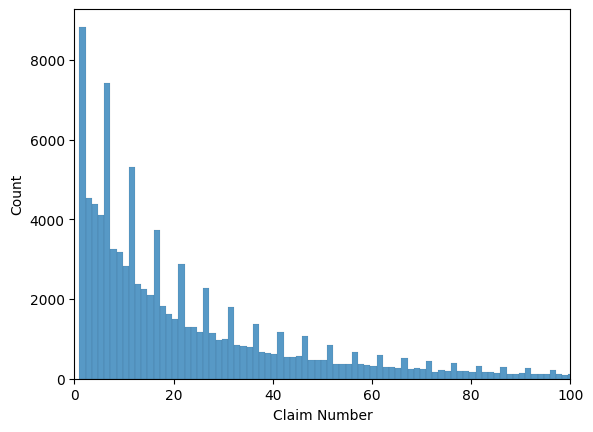

In [34]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.histplot(df_medical_data.groupby(by='Member Life ID',as_index=False)['Claim Number'].nunique()['Claim Number'])
plt.xlim(0, 100)
plt.show()

In [43]:
df_subset=df_medical_data.groupby(by='Member Life ID',as_index=False)['Claim Number'].nunique().rename(columns={'Claim Number':'num_unique_claims'})
member_id_to_keep=list(df_subset[df_subset['num_unique_claims']==3]['Member Life ID'].unique())
df_medical_data_subset=df_medical_data[df_medical_data['Member Life ID'].isin(member_id_to_keep)].reset_index(drop=True)

In [44]:
len(member_id_to_keep)

4521

In [45]:
# df_subset=df_medical_data.groupby(by='Member Life ID',as_index=False)['Claim Number'].nunique().rename(columns={'Claim Number':'num_unique_claims'})
# member_id_to_keep=list(df_subset[df_subset['num_unique_claims']<=5]['Member Life ID'].unique())
# df_medical_data_subset=df_medical_data[df_medical_data['Member Life ID'].isin(member_id_to_keep)].reset_index(drop=True)

In [46]:
df_medical_data_subset['Patient ID']=df_medical_data_subset['Member Life ID'].map(dict(zip(df_medical_data_subset['Member Life ID'].unique(),range((df_medical_data_subset['Member Life ID'].nunique())))))

In [48]:
df_medical_data_subset.columns=[x.replace(' ','_').lower() for x in df_medical_data_subset.columns]

In [52]:
patient_data=df_medical_data_subset[df_medical_data_subset['member_life_id']==470]
for patient_id in list(df_medical_data_subset["patient_id"].unique()):
  patient_data=df_medical_data_subset[df_medical_data_subset['patient_id']==patient_id]
range(patient_data.shape[0])

range(0, 3)

In [53]:
df_medical_data_subset

,member_life_id,gender_code,claim_number,current_procedural_terminology,primary_diagnosis_code-icd10,line_service_from_date,line_service_thru_date,billed_amount,paid_amount,patient_id
0,3838,F,710270216200,90833,F341,2017-03-31,2017-03-31,100.0,0.00,0
1,3838,F,719570192800,90833,F341,2017-06-09,2017-06-09,100.0,0.00,0
2,3838,F,727770451700,90833,F341,2017-09-01,2017-09-01,100.0,0.00,0
3,7054,M,026182193595900,12002,S61212A,2018-07-26,2018-07-26,337.0,103.96,1
4,7054,M,026182273878400,99211,S61212D,2018-08-05,2018-08-05,62.0,23.65,1
...,...,...,...,...,...,...,...,...,...,...
13558,38148316,M,A084P0416900,99204,P599,2017-04-18,2017-04-18,210.0,0.00,4519
13559,38148316,M,A189I0309400,*,Z3800,2017-04-12,2017-04-13,2600.0,0.00,4519
13560,38541263,M,731418296500,99393,Z00129,2017-11-07,2017-11-07,175.0,68.07,4520
13561,38541263,M,831919010100,99393,Z00129,2018-11-12,2018-11-12,175.0,68.07,4520


In [54]:
df_medical_data_subset=df_medical_data_subset[['member_life_id','gender_code',
       'current_procedural_terminology', 'primary_diagnosis_code-icd10',
       'line_service_from_date', 'line_service_thru_date', 'billed_amount',
       'paid_amount']].rename(columns={'member_life_id':'patient_id','current_procedural_terminology':'cpt_code','primary_diagnosis_code-icd10':'primary_diagnosis_code','line_service_from_date':'visit_start_date','line_service_thru_date':'visit_end_date'})

In [55]:
df_medical_data_subset['visit_start_date']=df_medical_data_subset['visit_start_date'].astype(str)
df_medical_data_subset['visit_end_date']=df_medical_data_subset['visit_end_date'].astype(str)

In [56]:
import pandas as pd

# Assuming we have a dataframe 'df' with the necessary columns.
# The function to be applied across the dataframe would look something like this:

def format_visit_information(row):
    # Extract the column names except 'patient_id' and 'gender_code'
    column_names = row.index.tolist()
    column_names.remove('patient_id')
    column_names.remove('gender_code')

    # Build the visit information string with column names and values
    visit_info = ", ".join(f"{col} is {row[col]}" for col in column_names)
    return f"{visit_info}"

# Applying the function to each row of the DataFrame and assigning the result to a new 'visit_info' column
# df['visit_info'] = df.apply(format_visit_information, axis=1)

# Now, assuming the dataframe contains multiple patients and we want to group by 'patient_id' and 'gender_code'
# and then apply the visit information formatting to each group.

# Modified function to concatenate visit information with each visit on a new line
def concatenate_visits(group):
    visit_details = group.apply(format_visit_information, axis=1).tolist()
    return "\n".join(f"<visit_{i+1}> : {details}" for i, details in enumerate(visit_details))

# Group by 'patient_id' and 'gender_code' and apply the concatenation function
# grouped_info = df.groupby(['patient_id', 'gender_code']).apply(concatenate_visits).reset_index(name='visit_info')

# The 'grouped_info' DataFrame will now have a summary string for each patient.

In [57]:
grouped_info = df_medical_data_subset.groupby(['patient_id', 'gender_code']).apply(concatenate_visits).reset_index(name='visit_info')

grouped_info

,patient_id,gender_code,visit_info
0,3838,F,"<visit_1> : cpt_code is 90833, primary_diagnos..."
1,7054,M,"<visit_1> : cpt_code is 12002, primary_diagnos..."
2,9296,M,"<visit_1> : cpt_code is 99213, primary_diagnos..."
3,12466,M,"<visit_1> : cpt_code is 99213, primary_diagnos..."
4,12937,M,"<visit_1> : cpt_code is 99395, primary_diagnos..."
...,...,...,...
4518,36162468,F,"<visit_1> : cpt_code is 99204, primary_diagnos..."
4519,36179853,M,"<visit_1> : cpt_code is 92587, primary_diagnos..."
4520,36222904,M,"<visit_1> : cpt_code is 99464, primary_diagnos..."
4521,38148316,M,"<visit_1> : cpt_code is 99391, primary_diagnos..."


In [58]:
grouped_info.to_csv('drive/MyDrive/Capgemini-Practicum/Dataset/patient_visit_info_3_visits.csv')

In [62]:
(grouped_info.loc[1,'visit_info'])

'<visit_1> : cpt_code is 12002, primary_diagnosis_code is S61212A, visit_start_date is 2018-07-26, visit_end_date is 2018-07-26, billed_amount is 337.0, paid_amount is 103.96\n<visit_2> : cpt_code is 99211, primary_diagnosis_code is S61212D, visit_start_date is 2018-08-05, visit_end_date is 2018-08-05, billed_amount is 62.0, paid_amount is 23.65\n<visit_3> : cpt_code is 92014, primary_diagnosis_code is H5203, visit_start_date is 2017-07-11, visit_end_date is 2017-07-11, billed_amount is 145.0, paid_amount is 72.76'

**Transforming each row into extra columns**

In [66]:
import pandas as pd
import re
# Function to extract and transform the data
def extract_and_transform(row):
    # Find all the visits
    visits = re.findall(r"<(visit_\d+)> : (.+?)\s*(?=<visit_\d+>|$)", row)

    # Dictionary to hold the extracted data
    extracted_data = {}

    for visit in visits:
        visit_name, visit_data = visit
        # Find all the key-value pairs in the visit
        key_values = re.findall(r"(\w+) is ([\w\d.-]+)", visit_data)
        for key, value in key_values:
            # Construct the new column name
            column_name = f"{visit_name}_{key}"
            extracted_data[column_name] = value

    return extracted_data

# Apply the function to each row and create a new DataFrame

extracted_rows = grouped_info['visit_info'].apply(extract_and_transform)
df_transformed = pd.concat([grouped_info[['patient_id','gender_code']],pd.DataFrame(extracted_rows.tolist())],axis=1)

df_transformed.head()

,patient_id,gender_code,visit_1_cpt_code,visit_1_primary_diagnosis_code,visit_1_visit_start_date,visit_1_visit_end_date,visit_1_billed_amount,visit_1_paid_amount,visit_2_cpt_code,visit_2_primary_diagnosis_code,visit_2_visit_start_date,visit_2_visit_end_date,visit_2_billed_amount,visit_2_paid_amount,visit_3_cpt_code,visit_3_primary_diagnosis_code,visit_3_visit_start_date,visit_3_visit_end_date,visit_3_billed_amount,visit_3_paid_amount
0,3838,F,90833,F341,2017-03-31,2017-03-31,100.0,0.0,90833,F341,2017-06-09,2017-06-09,100.0,0.0,90833,F341,2017-09-01,2017-09-01,100.0,0.0
1,7054,M,12002,S61212A,2018-07-26,2018-07-26,337.0,103.96,99211,S61212D,2018-08-05,2018-08-05,62.0,23.65,92014,H5203,2017-07-11,2017-07-11,145.0,72.76
2,9296,M,99213,M25511,2017-02-13,2017-02-13,75.0,0.0,97811,M25511,2017-02-20,2017-02-20,105.0,0.0,97811,M25512,2017-02-27,2017-02-27,105.0,0.0
3,12466,M,99213,Z98890,2017-01-09,2017-01-09,160.0,44.36,V2020,H5210,2017-05-06,2017-05-06,150.0,0.0,99213,J020,2017-06-09,2017-06-09,144.0,59.36
4,12937,M,99395,Z0000,2017-02-24,2017-02-24,135.0,122.35,99395,Z0000,2017-02-24,2017-02-24,-135.0,-122.35,99395,Z0000,2017-02-24,2017-02-24,135.0,0.0


**Prompt to Transform grouoed_info into a single prompt for model input**

In [90]:
def prompt(row):
  column_names = row.index.tolist()
  prompt = ", ".join(f"{col} is {row[col]}" for col in column_names[:-1])
  prompt+=f", {column_names[-1]} is\n{row[column_names[-1]]}"
  return f"{prompt}"

In [93]:
print(grouped_info.apply(lambda x:prompt(x), axis=1).iloc[1])

patient_id is 470, gender_code is M, visit_info is
<visit_1> : cpt_code is T2022, primary_diagnosis_code is R6889, visit_start_date is 2018-01-31, visit_end_date is 2018-01-31, billed_amount is 395.0, paid_amount is 395.0
<visit_2> : cpt_code is T2023, primary_diagnosis_code is F322, visit_start_date is 2018-01-12, visit_end_date is 2018-01-12, billed_amount is 390.0, paid_amount is 390.0
<visit_3> : cpt_code is 99214, primary_diagnosis_code is F331, visit_start_date is 2018-05-16, visit_end_date is 2018-05-16, billed_amount is 256.0, paid_amount is 169.77
